In [1]:
!pip install pyspark

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
#from sklearn.metrics import silhouette_score

#import pandas as pd
import matplotlib.pyplot as plt



In [3]:
spark = SparkSession.builder \
    .appName("Cluster Analysis") \
    .getOrCreate()

In [4]:
spark_df = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun_violence_cleaned_data_2013_2018.csv")

## K-Means analysis considering number of killings, number of injuries, number of guns involved, and gun type

In [5]:
# Assemble the desired featuers into a single columnn vector
features = ['n_killed',
            'n_injured',
            'n_guns_involved']
gun_type_cols = [col for col in spark_df.columns if col.startswith("gun_type")]
features = features + gun_type_cols

assembler = VectorAssembler(inputCols = features, outputCol = 'features')
all_variables_df = assembler.transform(spark_df)

# Scale the features
scaler = StandardScaler(inputCol = 'features', outputCol= 'scaled_features')
scaled_df = scaler.fit(all_variables_df).transform(all_variables_df)

In [8]:
def optimal_clusters(df, max_k = 25): # used for data/features that are not scaled
  """
  Creates an elbow plot that displays the inertia value for each number of clusters.
  Can be used to determine the optimal number of clusters based on the
  rate of change of the inertia values.

  Parameters:
  df (DataFrame): The DataFrame containing the features to perform the K-Means algorithm with.
  max_k (int): The maximum number of clusters to test.

  Returns:
  None: Displays the elbow plot.
  """
  number_of_clusters = []
  wsse = []

  for num in range(3, max_k):
    kmeans = KMeans(featuresCol = 'features', k = num, seed = 42)
    model = kmeans.fit(df)

    cost = model.summary.trainingCost

    number_of_clusters.append(num)
    wsse.append(cost)

  fig = plt.subplots(figsize = (10, 5))
  plt.plot(number_of_clusters, wsse, 'o-')
  plt.xlabel('Number of clusters')
  plt.ylabel('Within-Cluster Sum of Squared Errors')
  plt.grid(True)
  plt.show()

In [9]:
def optimal_clusters_scaled(df, max_k = 25): # used for data/features that are not scaled
  """
  Creates an elbow plot that displays the inertia value for each number of clusters.
  Can be used to determine the optimal number of clusters based on the
  rate of change of the inertia values.

  Parameters:
  df (DataFrame): The DataFrame containing the features to perform the K-Means algorithm with.
  max_k (int): The maximum number of clusters to test.

  Returns:
  None: Displays the elbow plot.
  """
  number_of_clusters = []
  wsse = []

  for num in range(3, max_k):
    kmeans = KMeans(featuresCol = 'scaled_features', k = num, seed = 42)
    model = kmeans.fit(df)

    cost = model.summary.trainingCost

    number_of_clusters.append(num)
    wsse.append(cost)

  fig = plt.subplots(figsize = (10, 5))
  plt.plot(number_of_clusters, wsse, 'o-')
  plt.xlabel('Number of clusters')
  plt.ylabel('Within-Cluster Sum of Squared Errors')
  plt.grid(True)
  plt.show()

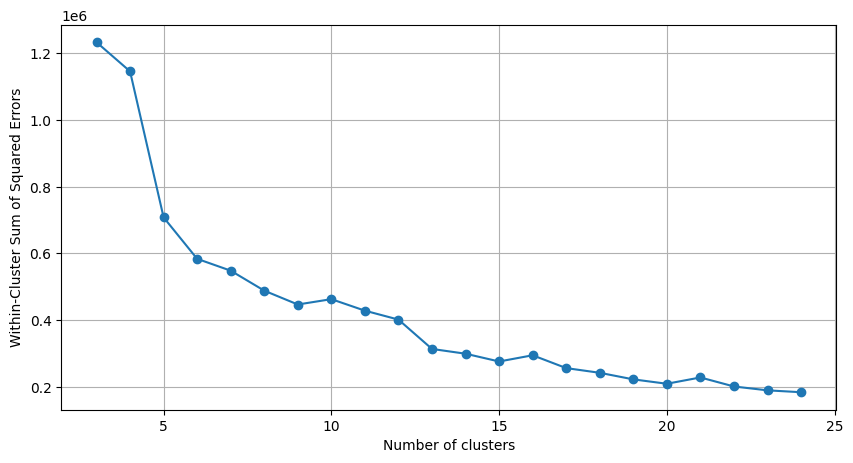

In [10]:
# Find the optimal number of clusters
optimal_clusters(all_variables_df)

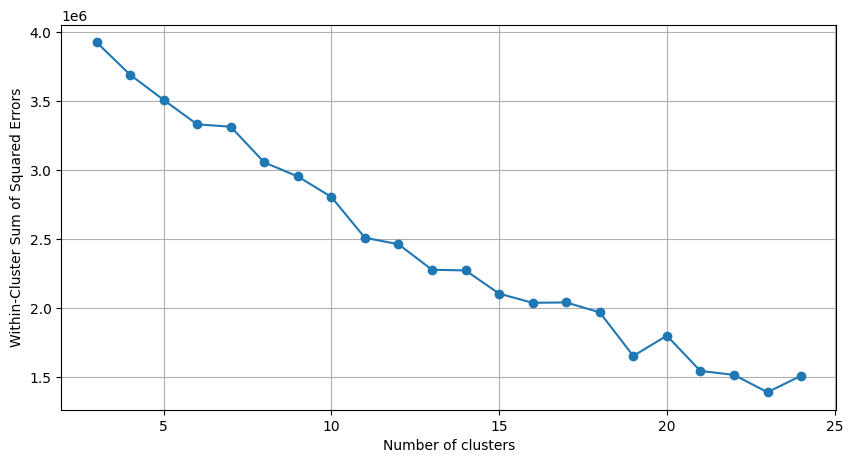

In [16]:
optimal_clusters_scaled(scaled_df)

From the elbow plot containing the unscaled data we see that the inertia’s rate of decrease seems to become less significant around k = 14, so we perform the k-means algorithm with 14 clusters.

In [12]:
# Evaluating the unscaled data
# Perform KMeans Clustering
kmeans = KMeans(featuresCol = 'features', k = 14, seed = 42)
model = kmeans.fit(all_variables_df)

# Make predictions
predictions = model.transform(all_variables_df)

# Evaluate the clustering with the Silhoutte score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print('Silhouette Score: {:.4f}'.format(silhouette))

Silhouette Score: 0.5165


From the elbow plot containing the scaled data we see that there is a rather steady rate of decrease throughout the different number of clusters, so we will choose to perform the k-means algorithm with 12 clusters rather than a larger number of clusters with a lower inertia value in an effort to retain some significance given to the meaning of each cluster and the insight it provides.

In [18]:
# Evaluating scaled data
# Perform KMeans Clustering
kmeans = KMeans(featuresCol = 'scaled_features', k = 12, seed = 42)
model = kmeans.fit(scaled_df)

# Make predictions
predictions = model.transform(scaled_df)

# Evaluate the clustering with the Silhoutte score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print('Silhouette Score: {:.4f}'.format(silhouette))

Silhouette Score: 0.2181


In [13]:
predictions.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|70439|
|         1|    6|
|         2|    7|
|         3|35848|
|         4|  218|
|         5|  616|
|         6|   13|
|         7| 2204|
|         8|   55|
|         9|   31|
|        10|88397|
|        11|26798|
|        12|    9|
|        13|15036|
+----------+-----+



Looking at the amount of data points assigned to each cluster, we see that clusters 2, 4, 6, and 7 have significantly less points which could potentially indicate outliers that make up these clusters. We also see that cluster 5 has the most data points by a large amount. We can investigate this cluster further to see if it possesses the prevailing trends within the database as a whole, however its dominating volume of data points along with the overall disproportion observed in the amount of data per cluster is likely a result of the relatively ineffective clustering that is reflected by the silhouette score of 0.2181 for the scaled data.

In [14]:
centroids_df = predictions.select(features + ['prediction']).groupBy('prediction').avg().orderBy('prediction').drop("avg(prediction)")

column_names = ['Prediction',
                'Average_Killed',
                'Average_Injured',
                'Average_Number_Guns_Involved',
                'Average_ak_Freq',
                'Average_auto_Freq',
                'Average_gauge_Freq',
                'Average_handgun_Freq',
                'Average_lr_Freq',
                'Average_mag_Freq',
                'Average_mm_Freq',
                'Average_rem_ar_Freq',
                'Average_rifle_Freq',
                'Average_shotgun_Freq',
                'Average_sql_Freq',
                'Average_spr_Freq',
                'Average_sw_Freq',
                'Average_Unknown_Freq',
                'Average_win_Freq']

centroids_df = centroids_df.toDF(*column_names)
centroids_df.show()

+----------+--------------------+--------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Prediction|      Average_Killed|     Average_Injured|Average_Number_Guns_Involved|     Average_ak_Freq|   Average_auto_Freq|  Average_gauge_Freq|Average_handgun_Freq|     Average_lr_Freq|    Average_mag_Freq|     Average_mm_Freq| Average_rem_ar_Freq|  Average_rifle_Freq|Average_shotgun_Freq|    Average_sql_Freq|    Average_spr_Freq|     Average_sw_Freq|Average_Unknown_Freq|    Average_win_Freq|
+----------+--------------------+--------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------

From an initial assessment of the centroids from each cluster there doesn’t appear to be any obvious features that provide useful insight to the patterns within clusters which again could be a result of the relatively low silhouette score that was given to the clustering. We do see that clusters 2, 6, and 7 have a higher average number of guns involved, however it was noted that these clusters could potentially be outliers given the small amount of data points in them.


## K-Means analysis considering number of killings and gun type

In [36]:
# Assemble the featuers into a single columnn vector using only numeric features
killings_features = ['n_killed']
killings_features = killings_features + gun_type_cols

assembler = VectorAssembler(inputCols = killings_features, outputCol = 'features')
killings_df = assembler.transform(spark_df)

# Scale the features
scaler = StandardScaler(inputCol = 'features', outputCol= 'scaled_features')
scaled_killings_df = scaler.fit(killings_df).transform(killings_df)

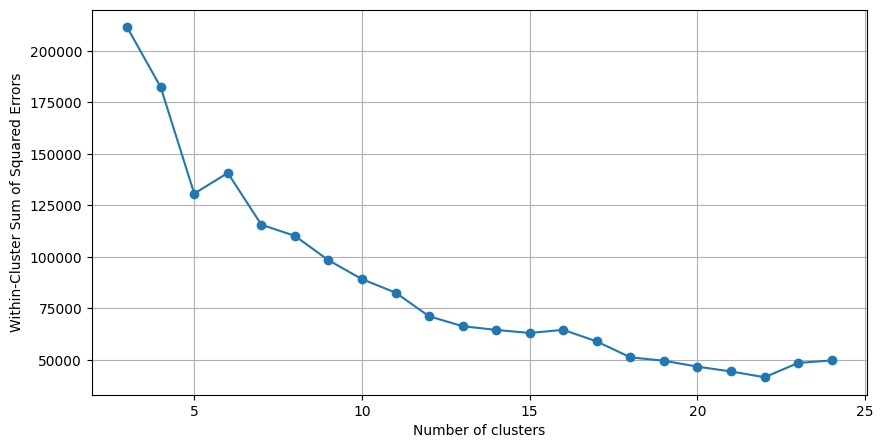

In [38]:
optimal_clusters(killings_df)

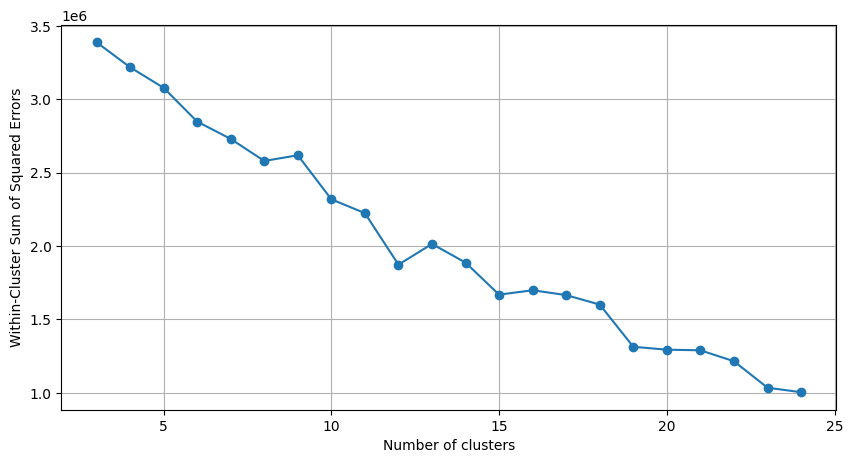

In [39]:
optimal_clusters_scaled(scaled_killings_df)

In [40]:
# Evaluating unscaled data
# Perform KMeans Clustering
kmeans = KMeans(featuresCol = 'features', k = 12, seed = 42)
killings_model = kmeans.fit(killings_df)

# Make predictions
killings_predictions = killings_model.transform(killings_df)

# Evaluate the clustering with the Silhoutte score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(killings_predictions)
print('Silhouette Score: {:.4f}'.format(silhouette))

Silhouette Score: 0.7481


In [41]:
# Evaluating scaled data
# Perform KMeans Clustering
kmeans = KMeans(featuresCol = 'scaled_features', k = 15, seed = 42)
scaled_killings_model = kmeans.fit(scaled_killings_df)

# Make predictions
scaled_killings_predictions = scaled_killings_model.transform(scaled_killings_df)

# Evaluate the clustering with the Silhoutte score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(scaled_killings_predictions)
print('Silhouette Score: {:.4f}'.format(silhouette))

Silhouette Score: 0.3367


In [42]:
scaled_killings_predictions.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|97774|
|         1|  794|
|         2|   71|
|         3|26033|
|         4|   12|
|         5| 5182|
|         6| 3313|
|         7| 1089|
|         8|  199|
|         9| 5388|
|        10|  942|
|        11|72566|
|        12|  184|
|        13|26017|
|        14|  113|
+----------+-----+



Examining the amount of data points assigned to each cluster, we see that clusters 2 and 4 along with a couple others have significantly less points which again could indicate outliers in these clusters. Similar to the original clustering done where the number of injuries and number of guns involved were included, this clustering has a rather low silhouette score of 0.3367 indicating a clustering result that is not great, which can partially be seen in the distribution of data points amongst the clusters.

In [48]:
killings_centroids_df = predictions.select(killings_features + ['prediction']).groupBy('prediction').avg().orderBy('prediction').drop("avg(prediction)")

killings_column_names = ['Prediction',
                'Average_Killed',
                'Average_ak_Freq',
                'Average_auto_Freq',
                'Average_gauge_Freq',
                'Average_handgun_Freq',
                'Average_lr_Freq',
                'Average_mag_Freq',
                'Average_mm_Freq',
                'Average_rem_ar_Freq',
                'Average_rifle_Freq',
                'Average_shotgun_Freq',
                'Average_sql_Freq',
                'Average_spr_Freq',
                'Average_sw_Freq',
                'Average_Unknown_Freq',
                'Average_win_Freq']

killings_centroids_df = killings_centroids_df.toDF(*killings_column_names)
killings_centroids_df.show()

+----------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+-------------------+
|Prediction|     Average_Killed|     Average_ak_Freq|   Average_auto_Freq|  Average_gauge_Freq|Average_handgun_Freq|     Average_lr_Freq|    Average_mag_Freq|     Average_mm_Freq| Average_rem_ar_Freq|  Average_rifle_Freq|Average_shotgun_Freq|    Average_sql_Freq|  Average_spr_Freq|     Average_sw_Freq|Average_Unknown_Freq|   Average_win_Freq|
+----------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------

## K-Means analysis considering number of injuries and gun type

In [49]:
# Assemble the featuers into a single columnn vector using only numeric features
injuries_features = ['n_injured']
injuries_features = injuries_features + gun_type_cols

assembler = VectorAssembler(inputCols = injuries_features, outputCol = 'features')
injuries_df = assembler.transform(spark_df)

# Scale the features
scaler = StandardScaler(inputCol = 'features', outputCol= 'scaled_features')
scaled_injuries_df = scaler.fit(injuries_df).transform(injuries_df)

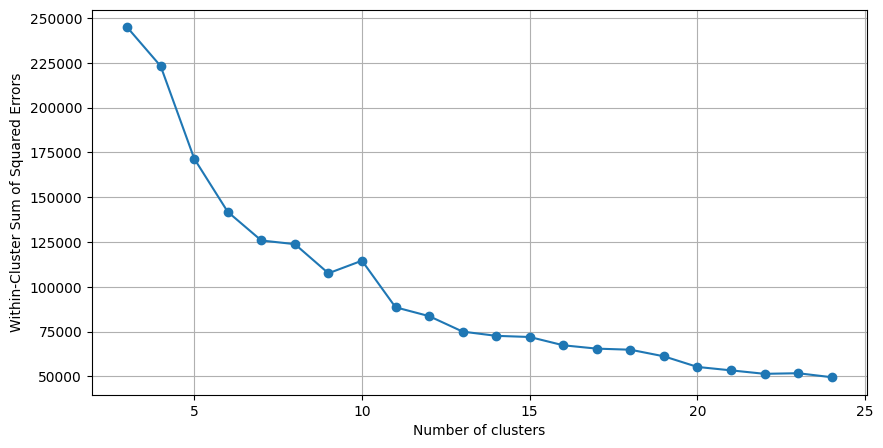

In [50]:
optimal_clusters(injuries_df)

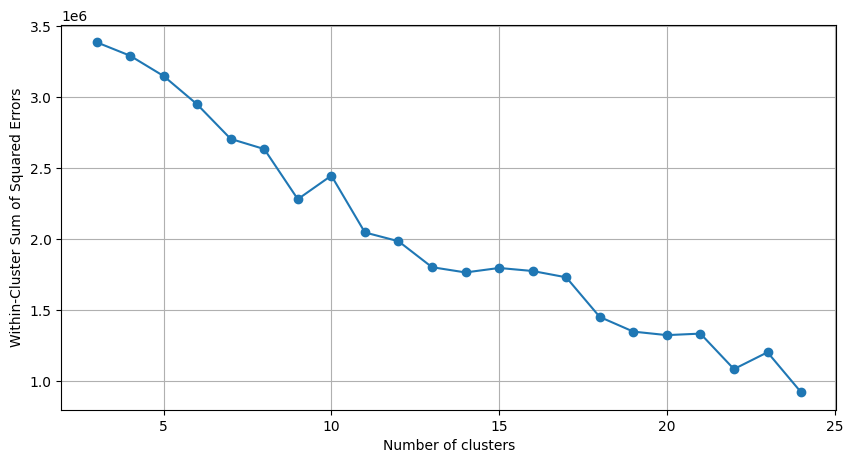

In [51]:
optimal_clusters_scaled(scaled_injuries_df)

In [52]:
# Evaluating unscaled data
# Perform KMeans Clustering
kmeans = KMeans(featuresCol = 'features', k = 11, seed = 42)
injuries_model = kmeans.fit(injuries_df)

# Make predictions
injuries_predictions = injuries_model.transform(injuries_df)

# Evaluate the clustering with the Silhoutte score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(injuries_predictions)
print('Silhouette Score: {:.4f}'.format(silhouette))

Silhouette Score: 0.6882


In [53]:
# Evaluating scaled data
# Perform KMeans Clustering
kmeans = KMeans(featuresCol = 'scaled_features', k = 13, seed = 42)
scaled_injuries_model = kmeans.fit(scaled_injuries_df)

# Make predictions
scaled_injuries_predictions = scaled_injuries_model.transform(scaled_injuries_df)

# Evaluate the clustering with the Silhoutte score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(scaled_injuries_predictions)
print('Silhouette Score: {:.4f}'.format(silhouette))

Silhouette Score: 0.3170


In [54]:
scaled_injuries_predictions.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|56494|
|         1|  939|
|         2|   12|
|         3| 1691|
|         4|  296|
|         5|   16|
|         6| 5127|
|         7| 1070|
|         8|  199|
|         9|   71|
|        10|91843|
|        11|81121|
|        12|  798|
+----------+-----+



In [55]:
injuries_centroids_df = predictions.select(injuries_features + ['prediction']).groupBy('prediction').avg().orderBy('prediction').drop("avg(prediction)")

injuries_column_names = ['Prediction',
                'Average_Injured',
                'Average_ak_Freq',
                'Average_auto_Freq',
                'Average_gauge_Freq',
                'Average_handgun_Freq',
                'Average_lr_Freq',
                'Average_mag_Freq',
                'Average_mm_Freq',
                'Average_rem_ar_Freq',
                'Average_rifle_Freq',
                'Average_shotgun_Freq',
                'Average_sql_Freq',
                'Average_spr_Freq',
                'Average_sw_Freq',
                'Average_Unknown_Freq',
                'Average_win_Freq']

injuries_centroids_df = injuries_centroids_df.toDF(*injuries_column_names)
injuries_centroids_df.show()

+----------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+-------------------+
|Prediction|    Average_Injured|     Average_ak_Freq|   Average_auto_Freq|  Average_gauge_Freq|Average_handgun_Freq|     Average_lr_Freq|    Average_mag_Freq|     Average_mm_Freq| Average_rem_ar_Freq|  Average_rifle_Freq|Average_shotgun_Freq|    Average_sql_Freq|  Average_spr_Freq|     Average_sw_Freq|Average_Unknown_Freq|   Average_win_Freq|
+----------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------